In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
CSV = "first_round_predictions.csv"
df = pd.read_csv(CSV)

In [6]:
print("Rows:", len(df))
print("top1_prob stats:")
print(df["top1_prob"].describe())

Rows: 5328
top1_prob stats:
count    5328.000000
mean        0.984434
std         0.067850
min         0.110718
25%         0.997917
50%         0.999838
75%         0.999994
max         1.000000
Name: top1_prob, dtype: float64


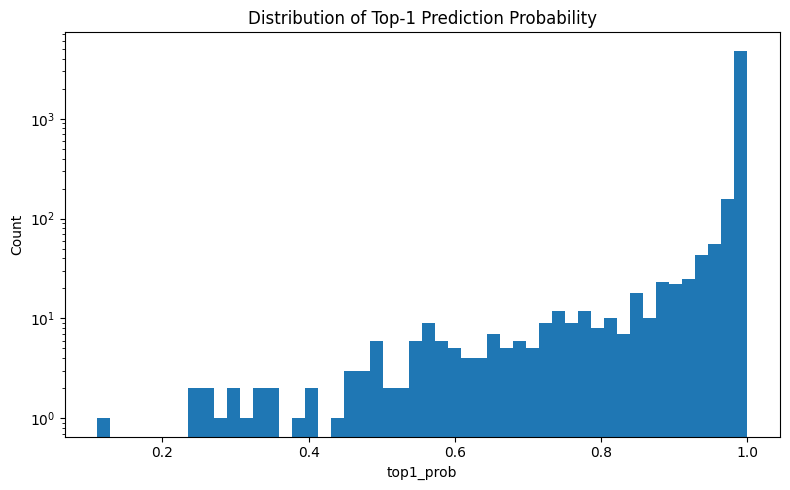

In [12]:
plt.figure(figsize=(8, 5))
plt.hist(df["top1_prob"], bins=50)
plt.xlabel("top1_prob")
plt.ylabel("Count")
plt.yscale("log")
plt.title("Distribution of Top-1 Prediction Probability")
plt.tight_layout()
plt.show()

In [14]:
probs = df[["top1_prob", "top2_prob", "top3_prob", "top4_prob", "top5_prob"]].values
entropy = -np.sum(probs * np.log(probs + 1e-12), axis=1)

df["entropy"] = entropy

print(df["entropy"].describe())

count    5.328000e+03
mean     4.569578e-02
std      1.521504e-01
min      5.780776e-10
25%      5.726786e-05
50%      1.321737e-03
75%      1.353770e-02
max      1.384863e+00
Name: entropy, dtype: float64


In [16]:
# Stratified sampling
bins = [0.0, 0.6, 0.8, 0.9, 0.99, 0.999, 0.9999, 1.0]
bin_labels = ["<0.6", "0.6-0.8", "0.8-0.9", "0.9-0.99", "0.99-0.999", "0.999-0.9999", ">0.9999"]

df["conf_bin"] = pd.cut(df["top1_prob"], bins=bins, labels=bin_labels, include_lowest=True)

# See how skewed it is
print(df["conf_bin"].value_counts().sort_index())

conf_bin
<0.6              58
0.6-0.8           81
0.8-0.9           74
0.9-0.99         460
0.99-0.999      1009
0.999-0.9999    1229
>0.9999         2417
Name: count, dtype: int64


In [17]:
df["log_entropy"] = np.log10(df["entropy"] + 1e-12)

print(df["log_entropy"].describe())

count    5328.000000
mean       -3.058132
std         1.601506
min        -9.237263
25%        -4.242089
50%        -2.878855
75%        -1.868455
max         0.141407
Name: log_entropy, dtype: float64


In [18]:
df["entropy_qbin"] = pd.qcut(df["log_entropy"], q=5, duplicates="drop")

print(df["entropy_qbin"].value_counts())

entropy_qbin
(-9.238, -4.526]    1066
(-3.323, -2.491]    1066
(-1.637, 0.141]     1066
(-4.526, -3.323]    1065
(-2.491, -1.637]    1065
Name: count, dtype: int64


In [19]:
bins = [-10, -7, -5, -3, -2, -1, 0.5]
labels = [
    "ultra_low",    # ~1e-10 to 1e-7
    "very_low",     # 1e-7 to 1e-5
    "low",          # 1e-5 to 1e-3
    "medium",       # 1e-3 to 1e-2
    "high",         # 1e-2 to 1e-1
    "very_high"    # 1e-1 to >1
]

df["entropy_bin"] = pd.cut(df["log_entropy"], bins=bins, labels=labels)

print(df["entropy_bin"].value_counts().sort_index())

entropy_bin
ultra_low      63
very_low      635
low          1792
medium       1353
high         1005
very_high     480
Name: count, dtype: int64


In [20]:
SAMPLES_PER_BIN = 100

sampled_parts = []

for bin_name, group in df.groupby("entropy_bin"):
    if len(group) == 0:
        continue

    n = min(SAMPLES_PER_BIN, len(group))  # don't oversample small bins
    sampled = group.sample(n=n, random_state=42)
    sampled_parts.append(sampled)

df_sampled = pd.concat(sampled_parts).reset_index(drop=True)

print("\nSampled dataset size:", len(df_sampled))
print("Bin counts after sampling:")
print(df_sampled["entropy_bin"].value_counts().sort_index())


Sampled dataset size: 563
Bin counts after sampling:
entropy_bin
ultra_low     63
very_low     100
low          100
medium       100
high         100
very_high    100
Name: count, dtype: int64


/var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/ipykernel_14158/3270644734.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin_name, group in df.groupby("entropy_bin"):


In [22]:
df_sampled = df_sampled.sample(frac=1.0, random_state=42).reset_index(drop=True)

df_sampled.to_csv("newdataset.csv", index=False)

print("\nSaved: newdataset.csv")


Saved: newdataset.csv
